### Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
import datetime
import joblib
import xgboost as xgb

### Load Data

In [2]:
train_data = pd.read_csv('../data/train_data_step3_features.csv')
train_data.head().T

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65.0,80.0,68.0,60.0,84.0
LotArea,8450,9600,11250,9550,14260
...,...,...,...,...,...
TotalGarageSize,550,462,610,645,839
OverallGrade,14021,11856,14007,13405,16000
BathsPerBed,0.833333,0.666667,0.833333,0.333333,0.625
LotFrontageToLotArea,0.007692,0.008333,0.006044,0.006283,0.005891


In [3]:
#encoding categorical variables
categorical_cols = train_data.select_dtypes(include=['object']).columns

#ordinal encoding
ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                'Functional', 'GarageFinish', 'Fence']

#define mapping for ordinal columns
quality_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}

#apply mapping
for col in ordinal_cols :
    train_data[col] = train_data[col].map(quality_mapping)

#one-hot encoding for nominal
nominal_cols = list(set(categorical_cols) - set(ordinal_cols))

#apply encoding
train_data = pd.get_dummies(train_data, columns=nominal_cols, drop_first=True)

#convert boolean columns to integers 1/0
train_data = train_data.applymap(lambda x: 1 if x is True else (0 if x is False else x))
print(train_data.head())

   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  ExterQual  ...  Electrical_Mix  Electrical_SBrkr  \
0          2003       196.0          4  ...               0                 1   
1          1976         0.0          3  ...               0                 1   
2          2002       162.0          4  ...               0                 1   
3          1970         0.0          3  ...               0                 1   
4          2000       350.0          4  ...               0                 1   

   Condition1_Feedr  Condition1_

C:\Users\aless\AppData\Local\Temp\ipykernel_14288\3956831161.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_data = train_data.applymap(lambda x: 1 if x is True else (0 if x is False else x))


### Feature Scaling

In [4]:
#select numerical features for scaling
numerical_features = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'TotalSF', 'HouseAge', 'TotalPorchSF', 'OverallQualCond', 'LotFrontage']

#going with standardization rather than normalization
scaler = StandardScaler()
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])
print(train_data[numerical_features].head())

   GrLivArea  TotalBsmtSF  1stFlrSF   TotalSF  HouseAge  TotalPorchSF  \
0   0.415310    -0.474485 -0.820365  0.028119 -1.048102     -0.244020   
1  -0.490601     0.537871  0.295435 -0.028210 -0.188253     -0.827353   
2   0.568992    -0.314902 -0.644475  0.215882 -0.981959     -0.425714   
3   0.429465    -0.723834 -0.531796 -0.096609  1.796014      2.108437   
4   1.402106     0.246133 -0.026113  1.070203 -0.948888     -0.024075   

   OverallQualCond  LotFrontage  
0         0.131551    -0.217074  
1         1.549050     0.500852  
2         0.131551    -0.073489  
3         0.131551    -0.456383  
4         0.676743     0.692299  


### Feature Selection

In [5]:
#correlation analysis with SalePrice
corr_matrix = train_data.corr()
corr_target = corr_matrix['SalePrice'].sort_values(ascending=False)
print(corr_target.head(15))

SalePrice                  1.000000
TotalSF                    0.822249
OverallGrade               0.806055
OverallQual                0.800173
TotalFinishedSF            0.741144
NeighborhoodMedianPrice    0.738466
GrLivArea                  0.719255
ExterQual                  0.692888
KitchenQual                0.666033
BsmtQual                   0.651360
GarageCars                 0.650858
TotalGarageSize            0.640573
GarageArea                 0.640282
TotalBsmtSF                0.638785
1stFlrSF                   0.617287
Name: SalePrice, dtype: float64


In [6]:
#remove low-correlation features (0.2 and below)
thresh = 0.2

#select features with correlation higher than 0.2 and drop others
selected_features = corr_target[abs(corr_target) > thresh].index
train_data_selected = train_data[selected_features]
print(train_data_selected.head())

   SalePrice   TotalSF  OverallGrade  OverallQual  TotalFinishedSF  \
0     208500  0.028119         14021            7             2416   
1     181500 -0.028210         11856            6             2240   
2     223500  0.215882         14007            7             2272   
3     140000 -0.096609         13405            7             1933   
4     250000  1.070203         16000            8             2853   

   NeighborhoodMedianPrice  GrLivArea  ExterQual  KitchenQual  BsmtQual  ...  \
0                 197200.0   0.415310          4            4       4.0  ...   
1                 218000.0  -0.490601          3            3       4.0  ...   
2                 197200.0   0.568992          4            4       4.0  ...   
3                 200624.0   0.429465          3            4       3.0  ...   
4                 301500.0   1.402106          4            4       4.0  ...   

   MasVnrType_BrkFace  LotFrontageToLotArea  RoofStyle_Gable  SaleType_WD  \
0                   1

In [7]:
#remove and replace inifinite values
train_data_selected.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data_selected.fillna(train_data_selected.median(), inplace=True)

C:\Users\aless\AppData\Local\Temp\ipykernel_14288\942336902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_selected.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\aless\AppData\Local\Temp\ipykernel_14288\942336902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_selected.fillna(train_data_selected.median(), inplace=True)


In [8]:
#variance thresh
#apply VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
train_data_high_variance = selector.fit_transform(train_data_selected)

#get features
selected_features_after_variance = train_data_selected.columns[selector.get_support()]
print(selected_features_after_variance)

Index(['SalePrice', 'TotalSF', 'OverallGrade', 'OverallQual',
       'TotalFinishedSF', 'NeighborhoodMedianPrice', 'GrLivArea', 'ExterQual',
       'KitchenQual', 'BsmtQual', 'GarageCars', 'TotalGarageSize',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'OverallQualCond', 'FullBath',
       'YearBuilt', 'TotRmsAbvGrd', 'YearRemodAdd', 'Foundation_PConc',
       'MasVnrArea', 'GarageYrBlt', 'Fireplaces', 'HeatingQC', 'BathsPerBed',
       'Neighborhood_NridgHt', 'BsmtFinSF1', 'SaleType_New',
       'SaleCondition_Partial', 'MasVnrType_Stone', 'GarageType_Attchd',
       'LotFrontage', 'OpenPorchSF', 'WoodDeckSF', 'Exterior2nd_VinylSd',
       'Exterior1st_VinylSd', '2ndFlrSF', 'FireplaceQu', 'HalfBath',
       'Neighborhood_NoRidge', 'LotArea', 'CentralAir_Y', 'GarageType_BuiltIn',
       'Electrical_SBrkr', 'MSZoning_RL', 'HouseStyle_2Story', 'PavedDrive_Y',
       'BsmtFullBath', 'RoofStyle_Hip', 'Neighborhood_StoneBr', 'BsmtUnfSF',
       'MasVnrType_BrkFace', 'RoofStyle_Gable', 'S

In [9]:
#further feature scaling pre-PCA
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data_selected[selected_features_after_variance])

#apply PCA
pca = PCA(n_components=20)
train_data_pca = pca.fit_transform(train_data_scaled)

#explained variance for each PC
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
print(f'Components: {pca.components_}')

Explained variance ratio: [0.28059751 0.07805431 0.06580767 0.05070006 0.03550872 0.03170399
 0.02989858 0.02710515 0.02636956 0.02452273 0.02158684 0.01945195
 0.01814098 0.01764419 0.01718486 0.01567707 0.01513459 0.01458763
 0.01387902 0.01311862]
Components: [[ 0.21661645  0.18722769  0.21053279 ... -0.11330357 -0.16736361
  -0.18377412]
 [ 0.103868    0.19463374 -0.00537047 ... -0.04322927  0.16016764
   0.11792142]
 [ 0.05262113  0.1055743   0.04871527 ...  0.10773099  0.02772011
   0.1510349 ]
 ...
 [ 0.03223052 -0.03599389  0.04752197 ... -0.06547584 -0.02822926
  -0.02832683]
 [ 0.00528676  0.10349836 -0.05755942 ...  0.12321107  0.06616847
  -0.10068214]
 [-0.00873534  0.01492544  0.01077659 ...  0.14012808 -0.04053034
  -0.02394849]]


### Inspect Imbalanced Data

C:\Users\aless\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


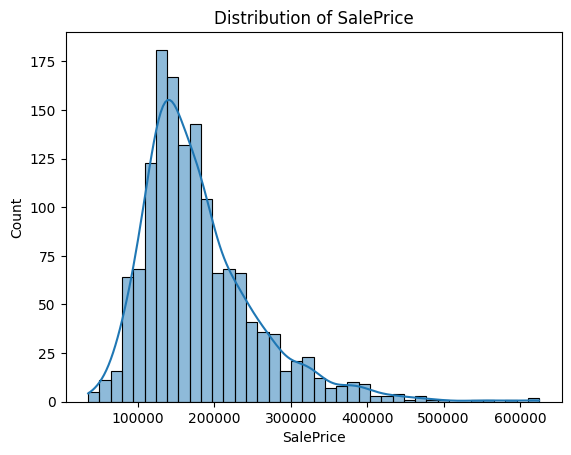

In [10]:
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.show()

In [11]:
#apply log transformation
train_data['SalePriceLog'] = np.log1p(train_data['SalePrice'])

### Splitting the Data

In [12]:
X = train_data_pca
y = train_data['SalePriceLog']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape, X_test.shape

((1162, 20), (291, 20))

In [14]:
y_train.shape, y_test.shape

((1162,), (291,))

### Preparing for Model Training

In [15]:
#linear regression
#initialize model
lr_model = LinearRegression()

#cross-validation
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lr_rmse_scores = np.sqrt(-lr_scores)
print(f"Linear Regression CV RMSE: {lr_rmse_scores.mean()} +/- {lr_rmse_scores.std()}")

Linear Regression CV RMSE: 0.11413080926846102 +/- 0.012455710625624606


In [16]:
#ridge regression
#initialize model
ridge_model = Ridge(alpha=1.0)

#cross-validation
ridge_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
ridge_rmse_scores = np.sqrt(-ridge_scores)
print(f"Ridge Regression CV RMSE: {ridge_rmse_scores.mean()} +/- {ridge_rmse_scores.std()}")

Ridge Regression CV RMSE: 0.11412723246484505 +/- 0.012458125393363703


In [17]:
#lasso regression
#initialize model
lasso_model = Lasso(alpha=0.1)

#cross-validation
lasso_scores = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lasso_rmse_scores = np.sqrt(-lasso_scores)
print(f"Lasso Regression CV RMSE: {lasso_rmse_scores.mean()} +/- {lasso_rmse_scores.std()}")

Lasso Regression CV RMSE: 0.14152008302827115 +/- 0.016437968514261044


In [18]:
#random forest
#initialize model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

#cross-validation
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_rmse_scores = np.sqrt(-rf_scores)
print(f"Random Forest CV RMSE: {rf_rmse_scores.mean()} +/- {rf_rmse_scores.std()}")

Random Forest CV RMSE: 0.12475397888472321 +/- 0.012823441163942798


In [19]:
#gradient boosting
#initialize model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)

#cross-validation
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_rmse_scores = np.sqrt(-xgb_scores)
print(f"XGBoost CV RMSE: {xgb_rmse_scores.mean()} +/- {xgb_rmse_scores.std()}")

XGBoost CV RMSE: 0.13136590226544348 +/- 0.012497631460164593


In [20]:
#hyperparameter tuning - Ridge
#set up parameter grid
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}

#initialize model and GridSearchCV
ridge_grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

#best parameters and score
print(f"Best Ridge parameters: {ridge_grid.best_params_}")
print(f"Best Ridge CV RMSE: {np.sqrt(-ridge_grid.best_score_)}")

Best Ridge parameters: {'alpha': 100.0}
Best Ridge CV RMSE: 0.11463226933697948


In [21]:
#model training and eval
best_ridge_model = ridge_grid.best_estimator_
best_ridge_model.fit(X_train, y_train)

#predict on test set
y_pred_log = best_ridge_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  #iInverse log transform

#evaluate the model
test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
print(f"Test RMSE: {test_rmse}")

Test RMSE: 18539.01255608193


In [22]:
#save model
save_dir = '../models'
#define filepath
save_path = os.path.join(save_dir, 'ridge_model.pkl')

#save the model
joblib.dump(best_ridge_model, save_path)

['../models\\ridge_model.pkl']